## Loading Data

In [1]:
import pandas as pd

cols = [
    'status',
    'duration',
    'history',
    'purpose',
    'amount',
    'savings',
    'employment_since',
    'installment_rate',
    'personal_status',
    'debtors',
    'residence_since',
    'property',
    'age',
    'installment_others',
    'housing',
    'existing_credits',
    'job',
    'people_being_liable',
    'telephone',
    'foreign_worker',
    'label'
]

credit = pd.read_csv('german.data', engine='python', sep='\s+', names=cols)
credit.head()

,status,duration,history,purpose,amount,savings,employment_since,installment_rate,personal_status,debtors,...,property,age,installment_others,housing,existing_credits,job,people_being_liable,telephone,foreign_worker,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Convert categorial data to numerical values

In [2]:
import numpy as np

def to_numerical(series):
    uniques = np.sort(series.unique())
    nvalues = range(1, len(uniques) + 1)
    xmap    = dict(zip(uniques, nvalues))

    return series.map(xmap).astype(int)


cols_not_to_convert = [
    'duration', 
    'installment_rate', 
    'age', 
    'amount',
    'existing_credits', 
    'people_being_liable', 
    'label'
]
cols_to_convert = [e for e in cols if e not in cols_not_to_convert]

for col in cols_to_convert:
    credit[col] = to_numerical(credit[col])
    
credit.head()

,status,duration,history,purpose,amount,savings,employment_since,installment_rate,personal_status,debtors,...,property,age,installment_others,housing,existing_credits,job,people_being_liable,telephone,foreign_worker,label
0,1,6,5,5,1169,5,5,4,3,1,...,1,67,3,2,2,3,1,2,1,1
1,2,48,3,5,5951,1,3,2,2,1,...,1,22,3,2,1,3,1,1,1,2
2,4,12,5,8,2096,1,4,2,3,1,...,1,49,3,2,1,2,2,1,1,1
3,1,42,3,4,7882,1,4,2,3,3,...,2,45,3,3,1,3,2,1,1,1
4,1,24,4,1,4870,1,3,3,3,1,...,4,53,3,3,2,3,2,1,1,2


## Soft features choice

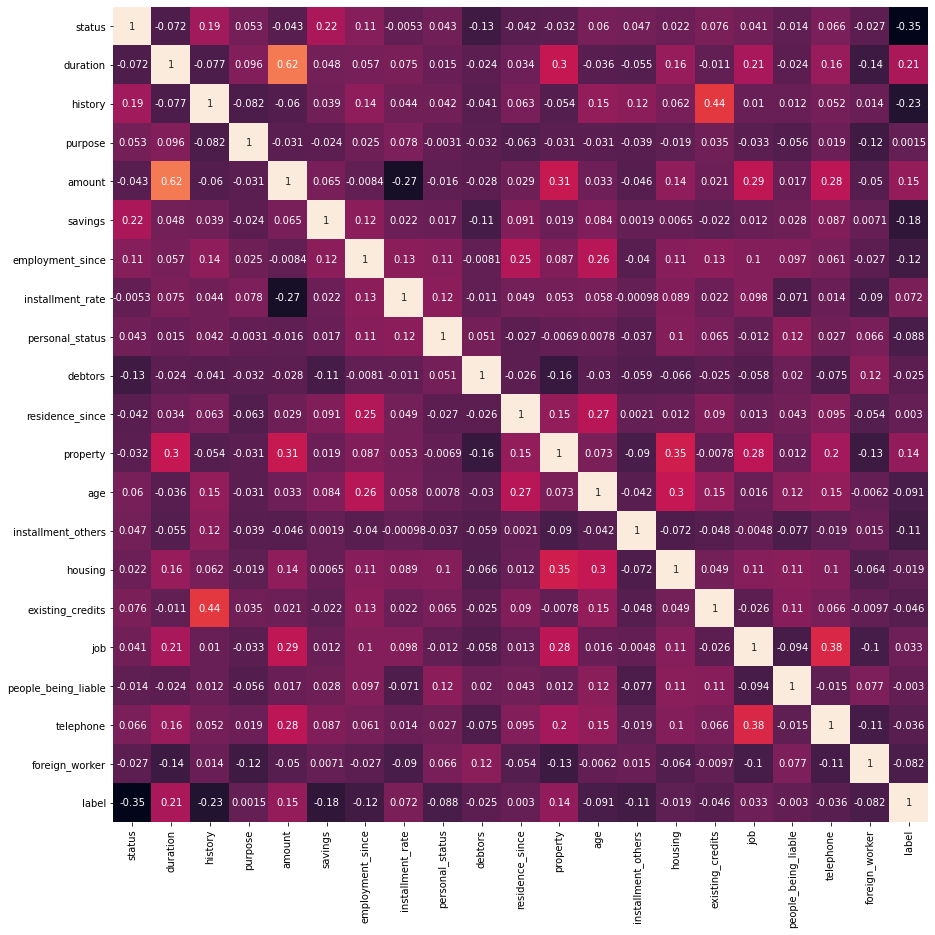

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr_matrix = np.corrcoef(credit.T)

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix,
    cbar=False,
    annot=True,
    square=True,
    xticklabels=cols,
    yticklabels=cols
)

In [4]:
feature_cols = [
    'duration', 
    'amount', 
    'job', 
    'age', 
    'history', 
    'employment_since', 
    'telephone', 
    'existing_credits', 
    'savings',
    'property'
]

## Creating X and y

In [5]:
X = credit[feature_cols]
y = credit['label']

## Cross validation

In [6]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

def extract_best_numbers(params, train_pcts, test_pcts):
    trains = pd.DataFrame(dict(zip(params, train_pcts))).T
    tests  = pd.DataFrame(dict(zip(params, test_pcts))).T
    
    trains['train_mean'] = trains.mean(axis=1)
    tests['test_mean']  = tests.mean(axis=1)
    
    return (trains[['train_mean']]
        .copy()
        .merge(
            tests[['test_mean']].copy(), 
            left_index=True, 
            right_index=True
        ))
        
def cross_validation_gamma(X, y, gamma_min, gamma_max):
    param_range = np.linspace(gamma_min, gamma_max, num=20)
    train_scores, test_scores = validation_curve(
        SVC(), 
        X, 
        y, 
        param_name="gamma", 
        param_range=param_range,
        cv=5)
    
    return extract_best_numbers(param_range, train_scores.tolist(), test_scores.tolist())

In [15]:
gamma_dataframe = cross_validation_gamma(X, y, 0.001, 1)
gamma_dataframe.head()

,train_mean,test_mean
0.001000,0.81425,0.672
0.053579,0.99500,0.699
0.106158,0.99825,0.700
0.158737,1.00000,0.700
0.211316,1.00000,0.700


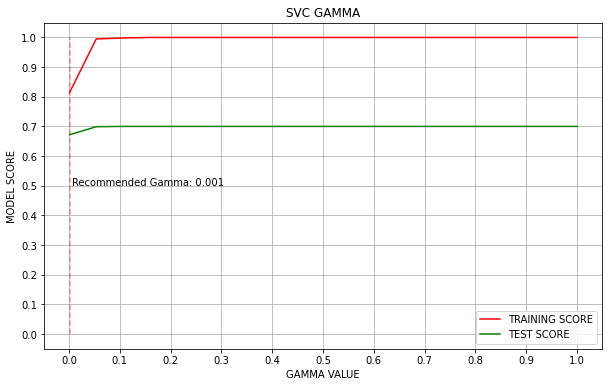

In [16]:
import matplotlib.pyplot as plt

def show_svc_param_performance(dataframe, param_name, threshold=0.8):
    x = dataframe.index

    plt.figure(figsize=(10, 6))
    plt.title("SVC {}".format(param_name.upper()))
    plt.xlabel('{} VALUE'.format(param_name.upper()))
    plt.ylabel('MODEL SCORE')
    plt.grid(axis='both')
    plt.yticks(np.arange(0.00, 1.10, step=0.10))
    plt.xticks(np.arange(0.00, 1.10, step=0.10))
    
    # drawing test and training performance lines
    plt.plot(x, dataframe['train_mean'], label='TRAINING SCORE', color='red')
    plt.plot(x, dataframe['test_mean'], label='TEST SCORE', color='green')
    
    # drawing limiy where train score is still ok
    limit_x = dataframe[dataframe['train_mean'] >= threshold].index[0]
    plt.vlines(limit_x, ymin=0, ymax=1, linestyle='--', color='red', alpha=0.4)
    plt.annotate("Recommended Gamma: {}".format(limit_x), xy=(limit_x + 0.005, 0.5))
    plt.legend(loc="lower right")
    plt.show()
    
show_svc_param_performance(gamma_dataframe, "gamma")

## Splitting dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

## Fit model

In [10]:
from sklearn.svm import SVC

svc = SVC().fit(X_train, y_train)

score_train = svc.score(X_train, y_train)
score_test  = svc.score(X_test, y_test)

score_train, score_test

(0.716, 0.7)

In [11]:
from sklearn.svm import SVC

gamma_value = 0.001

svc = SVC(gamma=gamma_value).fit(X_train, y_train)

score_train = svc.score(X_train, y_train)
score_test  = svc.score(X_test, y_test)

score_train, score_test

(0.8066666666666666, 0.68)

## Iterate

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [13]:
scaled_cross_validation = cross_validation_gamma(X_train_scaled, y_train, 1, 5)
scaled_cross_validation.head()

,train_mean,test_mean
1.000000,0.767000,0.729333
1.210526,0.775000,0.721333
1.421053,0.783333,0.721333
1.631579,0.792333,0.722667
1.842105,0.798667,0.726667


In [14]:
from sklearn.preprocessing import MinMaxScaler

svc = SVC(gamma=1).fit(X_train_scaled, y_train)

score_train = svc.score(X_train_scaled, y_train)
score_test  = svc.score(X_test_scaled, y_test)

score_train, score_test

(0.7666666666666667, 0.724)